### Notebook for preprocessing Sentinel-2 from GEE

In [1]:
#atmospheric correction module
from Py6S import *
from python.atmospheric import Atmospheric

#other modules
import json
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image,ImageDraw,ImageFont
import urllib.request
from glob import glob
import math
import datetime


#GEE modules
import ee
from geemap import *

#initialize GEE 
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()
    
#alter width notebook page   
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


#### Compute Sentinel-2 mosaics

In [2]:
#helper functions
def create_mosaic(collection,date_list):
    
    def match_date(date):
        dt = ee.Date(date).format('yyyy-MM-dd')
        dm = ee.Date(date).format('yyyy-MM')
        return collection.filter(ee.Filter.eq('system:time_start', date)).mosaic().set({'Date':dt,'Month':dm})
        
    return date_list.map(match_date)

def export_frames(collection,aoi,dir_name,annot_list,bands = ['B11', 'B8', 'B3']):
    
    print(f'Exporting {len(annot_list)} frames...')
    
    args = {'dimensions': 540,'bands': bands,'gain': [0.08, 0.08, 0.08],'region': aoi}
    url = collection.getFilmstripThumbURL(args)
    
    os.makedirs(dir_name,exist_ok=True)

    saved_strips = urllib.request.urlretrieve(url,f'{dir_name}.png')[0]
    
    img_arr = np.array(Image.open(saved_strips))
    img_stack = img_arr.reshape(len(annot_list),img_arr.shape[0]//len(annot_list),img_arr.shape[1],img_arr.shape[2])
    
    for i in range(len(annot_list)):
        img_pil = Image.fromarray(img_stack[i])
        ImageDraw.Draw(img_pil).text((0, 0),annot_list[i],font = ImageFont.truetype("arial.ttf", 20),fill=(124,252,0))
        annot= annot_list[i]
        fn = f"{dir_name}/{dir_name.split('/')[-1]}_{annot}.png"  
        img_pil.save(fn)
        
    os.remove(saved_strips)
    print(f'{len(annot_list)} frames exported in {dir_name}')
    
def plot_rgb(img,text,bands = ['B4', 'B3', 'B2']):
    viz_rgb = {'bands': bands,'gain': [0.1, 0.1, 0.1],'scale':90}
    Map.addLayer(img, viz_rgb, text+' RGB')

In [3]:
#study area
study_area = './data/boundaries/ramsar_stlucia_buffer.geojson'

with open(study_area) as f:
    coord = json.load(f)['features'][0]['geometry']['coordinates'][0]
    geom = ee.Geometry.Polygon(coord)

Map = geemap.Map(center=[-27.93186,32.48897],zoom=9)
Map.addLayer(ee_object=geom, vis_params={'color':'red'}, name="Lesser Isimangaliso Wetland Park")
Map

Map(center=[-27.93186, 32.48897], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

In [ ]:
def set_dates(img):
    dt = ee.Date(img.get('system:time_start')).format('yyyy-MM-dd')
    return img.set({'Date':dt})

band_names = ['B1','B2','B3','B4','B5','B6','B7']
l8_col = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR") \
    .filterBounds(geom).filterDate('2017-01-01','2017-12-31').map(lambda x:x.clip(geom)).select(band_names).map(set_dates)

l8_list = l8_col.toList(l8_col.size())

In [ ]:
def create_mosaic_l8(collection,date_list):
    
    def match_date(date):
        return collection.filter(ee.Filter.eq('Date', date)).mosaic().set({'Date':date})
        
    return date_list.map(match_date)
    
#create mosaics
s8_mos = create_mosaic_l8(l8_col,l8_col.aggregate_array('Date').distinct())
s8_mos_col = ee.ImageCollection(s8_mos).sort('Date')


In [ ]:
l8_dates = s8_mos_col.aggregate_array('Date').getInfo()
visParams = {'bands': ['B4', 'B3', 'B2'],'min': 0,'max': 3000,'gamma': 1.4,}
for i in range(len(l8_dates)):
    Map.addLayer(ee.Image(s8_mos.get(i)), visParams,l8_dates[i])

In [ ]:
# def get_values(n):
#     return ee.Number(ee.Image(n).reduceRegion(reducer= ee.Reducer.mean(),geometry=geom,scale=5000,maxPixels= 1e6).get('precipitation'))

# chirp_col = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").filterBounds(geom).filterDate('2017-01-01','2017-12-31').select('precipitation').map(lambda x:x.clip(geom))
# chip_col_list = chirp_col.toList(chirp_col.size())
# rain_values = chip_col_list.map(get_values).getInfo()
# dates = chirp_col.aggregate_array('system:index').getInfo()
# rain_df = pd.DataFrame([np.array(dates),np.array(rain_values)]).T
# rain_df.columns = ['Date','mm']
# rain_df['Date'] = pd.to_datetime(rain_df['Date'].astype(str))
# rain_df['mm'] = rain_df['mm'].astype(float)

# rain_df.to_csv('./data/rain_data.csv')

In [4]:
#get Sentinel-2 Level-1C collection for 2017 with less than 50% cloud cover

cl_pct = 50

band_names = ['B2','B3','B4','B5','B6','B7','B8','B8A','B10','B11','B12']

s2_col = ee.ImageCollection("COPERNICUS/S2") \
    .filterBounds(geom).filterDate('2017-01-01','2017-12-31') \
    .filter(ee.Filter.inList('MGRS_TILE', ['36JVP','36JVQ'])) \
    .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', cl_pct)).map(lambda x:x.clip(geom)).select(band_names)

s2_col_list = s2_col.toList(s2_col.size())

print(s2_col.filter(ee.Filter(ee.Filter.eq('MGRS_TILE', '36JVQ'))).size().getInfo(),' - 36JVQ images')
print(s2_col.filter(ee.Filter(ee.Filter.eq('MGRS_TILE', '36JVP'))).size().getInfo(),' - 36JVP images')


68  - 36JVQ images
68  - 36JVP images


In [5]:
#get unique dates
un_dates = s2_col.aggregate_array('system:time_start').distinct()

#get number of images with respect to matching dates
get_nr_match = lambda x: (s2_col.filter(ee.Filter.eq('system:time_start', x)).size(),x)
matches = un_dates.map(get_nr_match).getInfo()

#filter dates that have two images
un_dates_fil = ee.List([b for a,b in matches if a==2])

#create mosaics
s2_mos = create_mosaic(s2_col,un_dates_fil)
s2_mos_col = ee.ImageCollection(s2_mos).sort('Date')

print('Nr. mosaics: ',s2_mos_col.size().getInfo())

Nr. mosaics:  62


In [ ]:
# # #export mosaics as PNGs for further visual inspection
# dir_name = './data/ts_animation/2017_cl50'

# annotations = list(map(lambda x:x.replace('-',''),s2_mos_col.aggregate_array('Date').getInfo()))

# export_frames(s2_mos_col,
#               geom,
#               dir_name,
#               annotations)

In [6]:
#select best mosaics 
selected_dir_name = './data/ts_animation/2017_cl50_selected'
selected_dates = [re.findall(r"(\d{8})",os.path.basename(path))[0] for path in glob.glob(f'{selected_dir_name}/*.png')]
date_format = pd.to_datetime(selected_dates).astype(str).tolist()

s2_toa_col = s2_mos_col.filter(ee.Filter.inList('Date',date_format))
print('Nr. selected mosaics: ',s2_toa_col.size().getInfo())

Nr. selected mosaics:  45


In [7]:
dates_df = pd.DataFrame(pd.to_datetime(date_format))
dates_fr = pd.DataFrame(np.unique(dates_df.iloc[:,0].dt.month,return_counts=True)).T
dates_fr.columns = ['month','freq']
dates_fr['month'] = dates_df.iloc[:,0].dt.strftime('%b').unique()
dates_fr.sort_values(by='month')
dates_fr = dates_fr.set_index('month')

In [9]:
dates_fr.T

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
freq,2,3,4,2,3,5,8,7,4,3,3,1


#### Collect solar and sensor metadata and atmospheric constituent for 6S radiative-transfer model

In [ ]:
# get solar and sensor angle metadata for 6S correction 

#solar metadata
raw_dates = s2_col.aggregate_array('system:time_start').map(lambda x:ee.Date(x).format('yyyy-MM-dd')).getInfo()
sun_ele = s2_col.aggregate_array('MEAN_SOLAR_ZENITH_ANGLE').getInfo()
sun_azi = s2_col.aggregate_array('MEAN_SOLAR_AZIMUTH_ANGLE').getInfo()
sun_data = np.array( [sun_ele,sun_azi] )

sun_df = pd.DataFrame(sun_data).T
sun_df.columns = ['MEAN_SOLAR_ZENITH_ANGLE','MEAN_SOLAR_AZIMUTH_ANGLE']
sun_df['Date'] = pd.to_datetime(raw_dates)

#sensor and  Extra-terrestrial solar irradiation (ESUN) metadata
band_names = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']
esun_data = {}
view_ele_data = {}
view_azi_data = {}
for b in band_names:
    esun_data[f'SOLAR_IRRADIANCE_{b}'] = s2_col.aggregate_array(f'SOLAR_IRRADIANCE_{b}').getInfo()
    view_ele_data[f'MEAN_INCIDENCE_ZENITH_ANGLE_{b}'] = s2_col.aggregate_array(f'MEAN_INCIDENCE_ZENITH_ANGLE_{b}').getInfo()   
    view_azi_data [f'MEAN_INCIDENCE_AZIMUTH_ANGLE_{b}'] = s2_col.aggregate_array( f'MEAN_INCIDENCE_AZIMUTH_ANGLE_{b}').getInfo()

#compute mean sensor viewing angles over all bands (variability in viewing angles is small, hence presumeably can be neglected)
view_ele_df = pd.DataFrame(view_ele_data).mean(1).rename('MEAN_INCIDENCE_ZENITH_ANGLE')
view_azi_df = pd.DataFrame(view_azi_data).mean(1).rename('MEAN_INCIDENCE_AZIMUTH_ANGLE')
esun_df = pd.DataFrame(esun_data)

#export to csv
sun_view_df = pd.concat([sun_df,view_ele_df,view_azi_df,esun_df],axis=1)
sun_view_df  = sun_view_df.groupby(['Date'],as_index=False).mean()
sun_view_df = sun_view_df[sun_view_df['Date'].isin(date_format)].reset_index(drop=True)

sun_view_df.to_csv('./data/sun_data.csv')

In [ ]:
#precompute atmospheric constituents for study area and each scene
#water vapour GEE data source: NCEP/NCAR Reanalysis Data, Water vapor ('NCEP_RE/surface_wv')
#ozone GEE data source: TOMS and OMI Merged Ozone Data ('TOMS/MERGED')
#aerosol GEE data source: MOD08_M3.006 Terra Atmosphere Monthly Global Product ('MODIS/006/MOD08_M3')

#open sun data
sun_data_df = pd.read_csv('./data/sun_data.csv', index_col=0)
dates = ee.List(sun_data_df['Date'].to_list())
point = ee.Geometry.Point(-27.93186,32.48897)

#get water vapour, ozone and aerosol optical thickness 
sun_data_df['h2o'] = dates.map(lambda x: Atmospheric.water(point,ee.Date(x))).getInfo()
sun_data_df['o3'] = dates.map(lambda x: Atmospheric.ozone(point,ee.Date(x))).getInfo()
sun_data_df['aot'] = dates.map(lambda x: Atmospheric.aerosol(point,ee.Date(x))).getInfo()

sun_data_df.to_csv('./data/sun_data.csv')


#### Perform atmospheric correction with 6S radiative-transfer model

Reflected sunlight can be described as follows (wavelength dependence is implied):

$ L = \tau\rho(E_{dir} + E_{dif})/\pi + L_p$

where L is at-sensor radiance, $\tau$ is transmissivity, $\rho$ is surface reflectance, $E_{dir}$ is direct solar irradiance, $E_{dif}$ is diffuse solar irradiance and $L_p$ is path radiance. There are five unknowns in this equation, 4 atmospheric terms ($\tau$, $E_{dir}$, $E_{dif}$ and $L_p$) and surface reflectance. The 6S radiative transfer code is used to solve for the atmospheric terms, allowing us to solve for surface reflectance.

$ \rho = \pi(L - L_p) / \tau(E_{dir} + E_{dif}) $

Cite: Sam Murphy (Jan 25, 2018)  
Source : https://github.com/samsammurphy/gee-atmcorr-S2/blob/master/jupyer_notebooks/sentinel2_atmospheric_correction.ipynb

In [ ]:
#helper functions

def spectralResponseFunction(bandname):
    """
    Extract spectral response function for given band name
    """

    bandSelect = {
        'B1':PredefinedWavelengths.S2A_MSI_01,
        'B2':PredefinedWavelengths.S2A_MSI_02,
        'B3':PredefinedWavelengths.S2A_MSI_03,
        'B4':PredefinedWavelengths.S2A_MSI_04,
        'B5':PredefinedWavelengths.S2A_MSI_05,
        'B6':PredefinedWavelengths.S2A_MSI_06,
        'B7':PredefinedWavelengths.S2A_MSI_07,
        'B8':PredefinedWavelengths.S2A_MSI_08,
        'B8A':PredefinedWavelengths.S2A_MSI_8A,
        'B9':PredefinedWavelengths.S2A_MSI_09,
        'B10':PredefinedWavelengths.S2A_MSI_10,
        'B11':PredefinedWavelengths.S2A_MSI_11,
        'B12':PredefinedWavelengths.S2A_MSI_12,
        }
    
    return Wavelength(bandSelect[bandname])

def toa_to_rad(bandname,ESUN,solar_z,toa):
    """
    Converts top of atmosphere reflectance to at-sensor radiance
    """
    
    # solar exoatmospheric spectral irradiance
    solar_angle_correction = math.cos(math.radians(solar_z))
    
    # Earth-Sun distance (from day of year)
    doy = date.timetuple().tm_yday
    d = 1 - 0.01672 * math.cos(0.9856 * (doy-4))# http://physics.stackexchange.com/questions/177949/earth-sun-distance-on-a-given-day-of-the-year
   
    # conversion factor
    multiplier = ESUN*solar_angle_correction/(math.pi*d**2)

    # at-sensor radiance
    rad = toa.select(bandname).multiply(multiplier)
    
    return rad

def surface_reflectance(bandname,rad):
    """
    Calculate surface reflectance from at-sensor radiance given waveband name
    """
    
    # run 6S for this waveband
    s.wavelength = spectralResponseFunction(bandname)
    s.run()
    
    # extract 6S outputs
    Edir = s.outputs.direct_solar_irradiance             #direct solar irradiance
    Edif = s.outputs.diffuse_solar_irradiance            #diffuse solar irradiance
    Lp   = s.outputs.atmospheric_intrinsic_radiance      #path radiance
    absorb  = s.outputs.trans['global_gas'].upward       #absorption transmissivity
    scatter = s.outputs.trans['total_scattering'].upward #scattering transmissivity
    tau2 = absorb*scatter                                #total transmissivity
    
    # radiance to surface reflectance
    ref = rad.subtract(Lp).multiply(math.pi).divide(tau2*(Edir+Edif))
    
    return ref

In [10]:
#compute surface reflectance for these bands 
band_names = ['B2','B3','B4','B5','B6','B7','B8','B8A','B10','B11','B12']

#get study area elevation (mean) in km
srtm_30m = ee.Image("USGS/SRTMGL1_003")
km = srtm_30m.reduceRegion(reducer = ee.Reducer.mean(),geometry =geom).get('elevation').getInfo()/1000

#open sun and atmospheric data
sun_data_df = pd.read_csv('./data/sun_data.csv', index_col=0)
sun_data_df['Date'] = pd.to_datetime(sun_data_df['Date'])


In [121]:
sun_data_df['Date_format'] = sun_data_df['Date'].dt.strftime('%d-%b')
sun_data_df = sun_data_df.set_index('Date_format')

In [12]:
round(km,3)

0.025

In [13]:
%%time

#collect surface reflectance images
s2_sr_col = []

#instantiate 6S object
s = SixS()

# specifiy Earth-Sun-satellite geometry constants
s.geometry = Geometry.User()                     
s.altitudes.set_sensor_satellite_level()
s.altitudes.set_target_custom_altitude(km)
s.aero_profile = AeroProfile.Maritime              #study area is next to the ocean, hence a maritime climate is expected to be dominant

for i in range(len(sun_data_df)):
    
    #get values from df
    date = sun_data_df.loc[i,'Date']
    h2o,o3,aot = sun_data_df.loc[i,['h2o','o3','aot']]
    solar_z,solar_a = sun_data_df.loc[i,['MEAN_SOLAR_ZENITH_ANGLE','MEAN_SOLAR_AZIMUTH_ANGLE']]
    view_z,view_a = sun_data_df.loc[i,['MEAN_INCIDENCE_ZENITH_ANGLE','MEAN_INCIDENCE_AZIMUTH_ANGLE']]
    
    #specifiy atmospheric constiutents 
    s.atmos_profile = AtmosProfile.UserWaterAndOzone(h2o,o3)
    s.aot550 = aot

    # specify Earth-Sun-satellite geometry variables
    s.geometry.view_z = view_z                 # sensor viewing zenith angle
    s.geometry.view_a = view_a                 # sensor viewing azimuth angle
    s.geometry.solar_z = solar_z               # solar zenith angle
    s.geometry.solar_a = solar_a               # solar azimuth angle
    s.geometry.month = date.month              # month  used for Earth-Sun distance
    s.geometry.day = date.day                  # day used for Earth-Sun distance
    
    #get TOA image (scaled to 0-1)
    toa = s2_toa_col.select(band_names).filter(ee.Filter.eq('Date',str(date.date()))).first().divide(10000)
    toa_b10 = s2_toa_col.select('B10').filter(ee.Filter.eq('Date',str(date.date()))).first().divide(10000)
    
    #compute SR for each band
    base_img = []
    for b in band_names:
        if b!='B10':
            esun = sun_data_df.loc[i,f'SOLAR_IRRADIANCE_{b}']
            rad = toa_to_rad(b,esun,solar_z,toa)
            b_sr = surface_reflectance(b,rad)
            base_img.append(b_sr)
        else:
            base_img.append(toa_b10)
            
    base_img = ee.Image(base_img).set({'Date':str(date.date()),'Month': date.date().strftime('%Y-%m')  })
    s2_sr_col.append(base_img)

#datatype is float with values between 0-1 --> rescale to int16 if necessary (with scale factor 10000)
s2_sr_col = ee.ImageCollection(s2_sr_col)


Wall time: 0 ns


#### Compare TOA and SR results

In [ ]:
#helper function
def sample_ts(img_col,feat_col,ref_type):
    band_names = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']
    img_col_list = img_col.toList(img_col.size())
    labels = feat_col.aggregate_array('desc').getInfo()

    df = []
    for label in labels:
        feat = ee.Feature(feat_col.filter(ee.Filter.eq('desc',label)).first())
        s2_median = []

        for band in band_names:
            extract_values = lambda x: ee.Image(x).sampleRegions(feat,scale= 90).first().get(band)
            band_median = img_col_list.map(extract_values).reduce('median').getInfo()
            s2_median.append(band_median) 

        data = pd.DataFrame(dict(zip(band_names,s2_median)),index=[f'{ref_type} {label}'])
        df.append(data)

    return pd.concat(df,0)

In [ ]:
%%time

sample = './data/sample/ts_atmocorr.geojson'

with open(sample) as sample_f:
    feat_col = ee.FeatureCollection(json.load(sample_f)['features'])

    toa_df = sample_ts(s2_toa_col,feat_col,'TOA')/10000
    sr_df = sample_ts(s2_sr_col,feat_col,'BOA')
    toa_sr_df = pd.concat([toa_df.T,sr_df.T],1)

    toa_sr_df.to_csv('./data/toa_boa_median_data.csv')

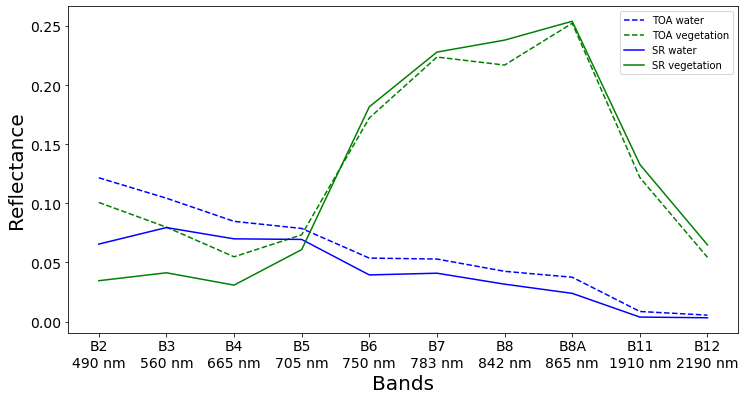

In [50]:
toa_sr_df = pd.read_csv('./data/toa_boa_median_data.csv',index_col=[0])
toa_sr_df.columns = ['TOA water','TOA vegetation','SR water','SR vegetation']
# nm = ['490','560','665','705','750','783','842','865','1910','2190']

# toa_sr_df.index = [f'{a}\n{b} nm' for a,b in zip(toa_sr_df.index,nm)]

ax = toa_sr_df.plot.line(color=['blue','green','blue','green'],
                                                  figsize=(12,6),
                                                  style=['--','--','-','-'],
                                                  xticks=range(len(toa_sr_df)),fontsize=14)

ax.set_xlabel('Bands',fontsize=20)
ax.set_ylabel('Reflectance',fontsize=20);
# ax.set_title('Comparison between TOA and Surface Reflectances for \n water (Wa) and vegetation (Ve) samples \n(median from time-series image collection)');



##### Export data

In [ ]:
#export surface reflectance

aoi = ee_to_geojson(geom)['coordinates'][0]

#uncomment for batch selection
# batch_1 = s2_sr_col.filter(ee.Filter.lt('Date','2017-07-20'))
batch_1 = s2_sr_col.filter(ee.Filter.gte('Date','2017-07-20'))

mask = ee.Image.constant(1).clip(geom).mask()

dates = batch_1.aggregate_array('Date').getInfo()

for i in range(len(dates)):
    file_name = f"mosaic_{ dates[i].replace('-','')}"
    
    data = batch_1.filter(ee.Filter.eq('Date', dates[i])).first().multiply(10000).toInt16().updateMask(mask).unmask(9999)

    task = ee.batch.Export.image.toDrive(data, 
                                         description='mosaic',
                                         folder='GEE_output',
                                         fileNamePrefix=file_name,
                                         crs='EPSG:32736',
                                         scale=10,
                                         maxPixels=1e8,
                                         fileFormat='GeoTIFF',
                                         skipEmptyTiles=True,
                                         region=aoi)
    task.start()

In [ ]:
#compute monthly median composites
study_area = './data/boundaries/ramsar_stlucia_buffer_datamask.geojson'
band_names = ['B2','B3','B4','B8','B11','B12']
with open(study_area) as f:
    coord = json.load(f)['features'][0]['geometry']['coordinates'][0]
    geom = ee.Geometry.Polygon(coord)
    
un_months = s2_sr_col.aggregate_array('Month').distinct().getInfo()

aoi = ee_to_geojson(geom)['coordinates'][0]
mask = ee.Image.constant(1).clip(geom).mask()

for i in range(len(un_months)):
    month = un_months[i]

    data = s2_sr_col.filter(ee.Filter.eq('Month',month)).map(lambda x:x.multiply(10000).toInt16()).median().set({'Month':month})
    data = data.select(band_names)
    task = ee.batch.Export.image.toDrive(data, 
                                     description='month_composite',
                                     folder='GEE_output',
                                     fileNamePrefix=f"mosaic_{month.replace('-','')}",
                                     crs='EPSG:32736',
                                     scale=10,
                                     maxPixels=1e8,
                                     fileFormat='GeoTIFF',
                                     skipEmptyTiles=True,
                                     region=aoi)
    task.start()

-1

In [ ]:
#compute selected median composite

aoi = ee_to_geojson(geom)['coordinates'][0]
mask = ee.Image.constant(1).clip(geom).mask()

selected_dates_cloud =  ['2017-01-06','2017-02-25','2017-03-27','2017-04-16','2017-05-16','2017-06-15',
                             '2017-07-05','2017-08-24','2017-09-08','2017-10-23','2017-11-17','2017-12-17']
year_composite = s2_sr_col.filter(ee.Filter.inList('Date',selected_dates_cloud)).map(lambda x:x.multiply(10000).toInt16().updateMask(mask).unmask(9999)).median()

task = ee.batch.Export.image.toDrive(year_composite , 
                                     description='composite',
                                     folder='GEE_output',
                                     fileNamePrefix='year_composite',
                                     crs='EPSG:32736',
                                     scale=10,
                                     maxPixels=1e8,
                                     fileFormat='GeoTIFF',
                                     skipEmptyTiles=True,
                                     region=aoi)
task.start()

In [ ]:
#check export status every 5 minutes
import time

starttime = time.time()
state = True
while state:
    s = task.status()['state']
    print(s)
    if s=='RUNNING' or s=='READY':
        time.sleep(60.0*5 - ((time.time() - starttime) % 60.0*5))

    else:
        state=False

#### Export JRC GSW 

In [ ]:
aoi = ee_to_geojson(geom)['coordinates'][0]

jrc_gsw_s = ee.ImageCollection("JRC/GSW1_1/YearlyHistory").filter(ee.Filter.eq('year',2017)).first().clip(geom)

task = ee.batch.Export.image.toDrive(jrc_gsw_s , 
                                     description='JRC_year',
                                     folder='GEE_output',
                                     fileNamePrefix='YearlyHistory_2017',
                                     crs='EPSG:32736',
                                     scale=10,
                                     maxPixels=1e8,
                                     fileFormat='GeoTIFF',
                                     skipEmptyTiles=True,
                                     region=aoi)
task.start()